INFO:drake:Meshcat listening for connections at http://localhost:7005


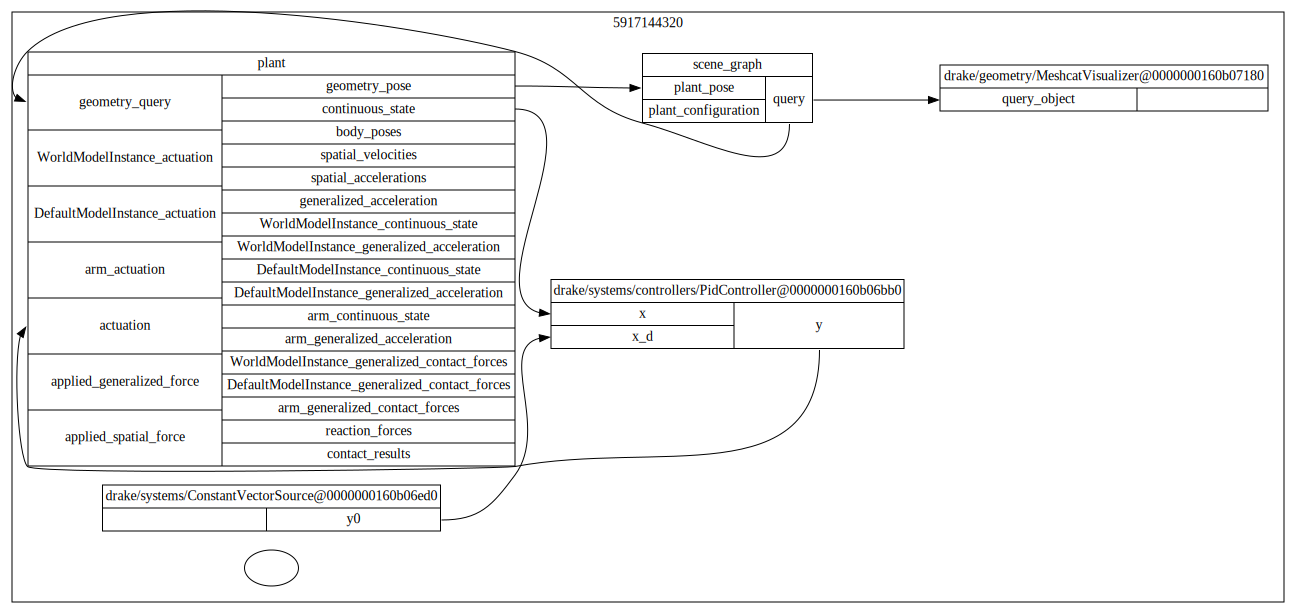

TypeError: SetPositions(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.multibody.plant.MultibodyPlant_[float], context: pydrake.systems.framework.Context_[float], q: numpy.ndarray[numpy.float64[m, 1]]) -> None
    2. (self: pydrake.multibody.plant.MultibodyPlant_[float], context: pydrake.systems.framework.Context_[float], model_instance: pydrake.multibody.tree.ModelInstanceIndex, q: numpy.ndarray[numpy.float64[m, 1]]) -> None

Invoked with: <pydrake.multibody.plant.MultibodyPlant_[float] object at 0x15fbd9230>, <pydrake.systems.framework.LeafContext_[float] object at 0x1609f70b0>, array([[ 0., 10.],
       [ 0., 20.],
       [ 0., 30.]])

In [5]:
import pydot
from IPython.core.display import SVG
from IPython.core.display_functions import display
from pydrake.all import Simulator, DiagramBuilder, AddMultibodyPlantSceneGraph,\
                        Parser, RigidTransform, MeshcatVisualizer, MeshcatVisualizerParams, \
                        ConstantVectorSource, ConstantValueSource, PiecewisePolynomial,\
                        AbstractValue, HalfSpace, CoulombFriction, SceneGraph, MultibodyPlant, AutoDiffXd, StartMeshcat
from pydrake.systems.controllers import PidController
import numpy as np

target_realtime_rate = 1.0
simulation_time = 10
max_time_step = 10e-3
Kp_ = 10.0
Ki_ = 20.0
Kd_ = 30.0

def controller():

    meshcat = StartMeshcat()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, max_time_step)
    parser = Parser(plant)
    parser.AddModelFromFile("arm.urdf")
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetBodyByName("base_z").body_frame(),
        RigidTransform.Identity()
    )
    plant.AddJointActuator("base", plant.GetJointByName("base"))
    plant.AddJointActuator("shoulder", plant.GetJointByName("shoulder"))
    plant.AddJointActuator("elbow", plant.GetJointByName("elbow"))

    plant.Finalize()

    Kp = np.ones(plant.num_positions()) * Kp_
    Ki = np.ones(plant.num_positions()) * Ki_
    Kd = np.ones(plant.num_positions()) * Kd_

    pid = builder.AddSystem(PidController(Kp, Ki, Kd))

    builder.Connect(plant.get_state_output_port(), pid.get_input_port_estimated_state())

    builder.Connect(pid.get_output_port_control(), plant.get_actuation_input_port())

    desired_base_source = builder.AddSystem(ConstantVectorSource(np.zeros(plant.num_multibody_states())))
    builder.Connect(desired_base_source.get_output_port(), pid.get_input_port_desired_state())


    # Handled by pydrake
    # id = plant.get_source_id()
    #
    # builder.Connect(plant.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(id))
    # builder.Connect(scene_graph.get_query_output_port(), plant.get_geometry_query_input_port())

    vis_params = MeshcatVisualizerParams(publish_period=0.1)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

    diagram = builder.Build()
    display(SVG(pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
    diagram_context = diagram.CreateDefaultContext()

    plant_context = diagram.GetMutableSubsystemContext(plant, diagram_context)

    positions = np.zeros((plant.num_positions(), 2))

    positions[0] = [0, 10]
    positions[1] = [0, 20]
    positions[2] = [0, 30]

    plant.SetPositions(plant_context, positions)

    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(target_realtime_rate)
    simulator.set_publish_every_time_step(True)

    simulator.AdvanceTo(simulation_time)

if __name__ == "__main__":
    controller()
